In [1]:
from importlib.metadata import version

pkgs = [
    "matplotlib",
    "numpy",
    "tiktoken",
    "torch",
    "tensorflow",
    "pandas"
]

for p in pkgs:
    print(f"{p} version: {version(p)}")

matplotlib version: 3.7.2
numpy version: 1.24.3
tiktoken version: 0.6.0
torch version: 2.0.1
tensorflow version: 2.13.0
pandas version: 2.0.3


In [2]:
import json
import os
import urllib

def download_and_load_file(file_path):
    with open(file_path, "r", encoding='utf-8') as f:
        data = json.load(f)
    
    return data

In [3]:
file_path = "instruction-data.json"
data = download_and_load_file(file_path)
len(data)

1100

In [4]:
def format_input(entry):
    instruction_text = (
        f"Below is an instruction that describes a task. Write a response that "
        f"appropriately completes the request."
        f"\n\n### Instruction:\n{entry['instruction']}"
    )
    input_text = f"\n\n### Input:\n{entry['input']}" if entry['input'] else ""
    return instruction_text + input_text

In [5]:
train_portion = int(len(data) * 0.85)
test_portion = int(len(data) * 0.10)

train_data = data[:train_portion]
test_data = data[train_portion: test_portion + train_portion]
val_data = data[train_portion + test_portion:]

len(train_data), len(test_data), len(val_data)

(935, 110, 55)

In [6]:
import tiktoken
tokenizer = tiktoken.get_encoding('gpt2')
print(tokenizer.encode("<|endoftext|>", allowed_special={"<|endoftext|>"}))

[50256]


In [7]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset

In [8]:
class InstructionDataset(Dataset):
    def __init__(self, data, tokenizer):
        self.data = data
        self.encoded_text = []
        for entry in data:
            entry_formatted = format_input(entry)
            response_text = f"\n\n### Response:\n{entry['output']}"
            full_text = entry_formatted + response_text
            self.encoded_text.append(
                tokenizer.encode(full_text)
            )
    
    def __getitem__(self, index):
        return self.encoded_text[index]
    
    def __len__(self):
        return len(self.encoded_text)

In [9]:
def custom_collate_draft_1(
    batch,
    pad_token_id=50256,
    device="cpu"
):
    # Find the longest sequence in the batch
    # and increase the max length by +1, which will add one extra
    # padding token below
    batch_max_length = max(len(item)+1 for item in batch)
    print(batch_max_length)

    # Pad and prepare inputs
    inputs_lst = []

    for item in batch:
        new_item = item.copy()
        # Pad sequences to batch_max_length
        padded = (
            new_item + [pad_token_id] *
            (batch_max_length - len(new_item))
        )
        # Via padded[:-1], we remove the extra padded token
        # that has been added via the +1 setting in batch_max_length
        # (the extra padding token will be relevant in later codes)
        inputs = torch.tensor(padded[:-1])
        inputs_lst.append(inputs)

    # Convert list of inputs to tensor and transfer to target device
    inputs_tensor = torch.stack(inputs_lst).to(device)
    return inputs_tensor

In [10]:
inputs_1 = [0, 1, 2, 3, 4]
inputs_2 = [5, 6]
inputs_3 = [7, 8, 9]
out = custom_collate_draft_1([inputs_1, inputs_2, inputs_3])

6


In [11]:
out.shape; out
out = out[2:].squeeze()
out.shape

torch.Size([5])

In [12]:
pad_token_id = 50256
mask = out == pad_token_id
mask

tensor([False, False, False,  True,  True])

In [13]:
indices = torch.nonzero(mask).squeeze()
indices.shape

torch.Size([2])

In [14]:
indices.numel()

2

In [15]:
indices[1:].shape

torch.Size([1])

In [16]:
out[indices[1:]] = -100

In [17]:
out

tensor([    7,     8,     9, 50256,  -100])

In [18]:
def custom_collate_fn(batch, pad_token_id=50256, ignore_index=-100, allowed_max_len=None, device='cpu'):
    batch_max_len = max(len(entry) + 1 for entry in batch)
    input_lst, target_lst = [], []
    
    for item in batch:
        new_item = item.copy()
        # Pad sequences to batch_max_length
        padded = (
            new_item + [pad_token_id] *
            (batch_max_len - len(new_item))
        )
        input = torch.tensor(padded[:-1])
        target = torch.tensor(padded[1:])

        # Only use padding token for first endoftext token
        mask = target == pad_token_id
        indices = torch.nonzero(mask).squeeze()
        if indices.numel() > 1:
            target[indices[1:]] = ignore_index
        
        if allowed_max_len is not None:
            input = input[:allowed_max_len]
            target = target[:allowed_max_len]
        
        input_lst.append(input)
        target_lst.append(target)
    
    input_tensor = torch.stack(input_lst).to(device)
    target_tensor = torch.stack(target_lst).to(device)
    
    return input_tensor, target_tensor

In [19]:
input_batch, target_batch = custom_collate_fn([inputs_1, inputs_2, inputs_3])
input_batch, target_batch

(tensor([[    0,     1,     2,     3,     4],
         [    5,     6, 50256, 50256, 50256],
         [    7,     8,     9, 50256, 50256]]),
 tensor([[    1,     2,     3,     4, 50256],
         [    6, 50256,  -100,  -100,  -100],
         [    8,     9, 50256,  -100,  -100]]))

In [20]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

In [21]:
from functools import partial
customized_collate_func = partial(
    custom_collate_fn, device=device, allowed_max_len=1024
)

In [22]:
from torch.utils.data import DataLoader

torch.manual_seed(123)
batch_size = 8

train_dataset = InstructionDataset(train_data, tokenizer)
len(train_dataset)
train_loader = DataLoader(
    train_dataset,
    collate_fn=customized_collate_func,
    batch_size=batch_size,
    shuffle=True,
    drop_last=True,
    num_workers=0
)

In [23]:
a = next(iter(train_loader))
a[0].shape, a[1].shape

(torch.Size([8, 61]), torch.Size([8, 61]))

In [24]:
val_dataset = InstructionDataset(val_data, tokenizer)
len(val_dataset)
val_loader = DataLoader(
    val_dataset,
    collate_fn=customized_collate_func,
    batch_size=batch_size,
    shuffle=False,
    drop_last=False,
    num_workers=0
)

In [25]:
a = next(iter(val_loader))
a[0].shape, a[1].shape

(torch.Size([8, 74]), torch.Size([8, 74]))

In [26]:
test_dataset = InstructionDataset(test_data, tokenizer)
len(test_dataset)
test_loader = DataLoader(
    test_dataset,
    collate_fn=customized_collate_func,
    batch_size=batch_size,
    shuffle=False,
    drop_last=False,
    num_workers=0
)

In [27]:
a = next(iter(val_loader))
a[0].shape, a[1].shape

(torch.Size([8, 74]), torch.Size([8, 74]))

In [28]:
from utils.gpt_download import download_and_load_gpt2
from utils.gpt_model import (
    generate_text_simple,
    GPTModel,
    load_weights_into_gpt,
    text_to_token_ids,
    token_ids_to_text,
    generate
)

In [29]:
BASE_CONFIG = {
    "vocab_size": 50257,     # Vocabulary size
    "context_length": 1024,  # Context length
    "drop_rate": 0.0,        # Dropout rate
    "qkv_bias": True         # Query-key-value bias
}

model_configs = {
    "gpt2-small (124M)": {"emb_dim": 768, "n_layers": 12, "n_heads": 12},
    "gpt2-medium (355M)": {"emb_dim": 1024, "n_layers": 24, "n_heads": 16},
    "gpt2-large (774M)": {"emb_dim": 1280, "n_layers": 36, "n_heads": 20},
    "gpt2-xl (1558M)": {"emb_dim": 1600, "n_layers": 48, "n_heads": 25},
}

CHOOSE_MODEL = "gpt2-medium (355M)"


In [30]:
model_size = CHOOSE_MODEL.split(" ")[-1].lstrip("(").rstrip(")")
settings, params = download_and_load_gpt2(
    model_size=model_size,
    models_dir="gpt2"
)

https://openaipublic.blob.core.windows.net/gpt-2/models/355M/checkpoint gpt2/355M/checkpoint
File exists: gpt2/355M/checkpoint
https://openaipublic.blob.core.windows.net/gpt-2/models/355M/encoder.json gpt2/355M/encoder.json
File exists: gpt2/355M/encoder.json
https://openaipublic.blob.core.windows.net/gpt-2/models/355M/hparams.json gpt2/355M/hparams.json
File exists: gpt2/355M/hparams.json
https://openaipublic.blob.core.windows.net/gpt-2/models/355M/model.ckpt.data-00000-of-00001 gpt2/355M/model.ckpt.data-00000-of-00001
File exists: gpt2/355M/model.ckpt.data-00000-of-00001
https://openaipublic.blob.core.windows.net/gpt-2/models/355M/model.ckpt.index gpt2/355M/model.ckpt.index
File exists: gpt2/355M/model.ckpt.index
https://openaipublic.blob.core.windows.net/gpt-2/models/355M/model.ckpt.meta gpt2/355M/model.ckpt.meta
File exists: gpt2/355M/model.ckpt.meta
https://openaipublic.blob.core.windows.net/gpt-2/models/355M/vocab.bpe gpt2/355M/vocab.bpe
File exists: gpt2/355M/vocab.bpe


In [31]:
BASE_CONFIG.update(model_configs[CHOOSE_MODEL])

model = GPTModel(BASE_CONFIG)
load_weights_into_gpt(model, params)
model.eval();

In [32]:
torch.manual_seed(123)
input_text = format_input(val_data[2])
print(input_text)
print(val_data[2])

Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
Rewrite the sentence using a metaphor.

### Input:
The book is very interesting.
{'instruction': 'Rewrite the sentence using a metaphor.', 'input': 'The book is very interesting.', 'output': 'The book is a page-turner.'}


In [33]:
token_ids = generate(
    model=model,
    idx=text_to_token_ids(input_text, tokenizer),
    max_new_tokens=35,
    context_size=BASE_CONFIG['context_length'],
    eos_id=50256,
)
generated_text = token_ids_to_text(token_ids, tokenizer)

In [34]:
print(generated_text)

Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
Rewrite the sentence using a metaphor.

### Input:
The book is very interesting.

### Output:

The book is very interesting.

### Instruction:

Write a response that appropriately completes the request.

### Input:



In [35]:
print(generated_text[len(input_text):].replace("### Response:", "").strip())

### Output:

The book is very interesting.

### Instruction:

Write a response that appropriately completes the request.

### Input:


In [36]:
from utils.gpt_model import (
    calc_loss_loader,
    train_model_simple
)

In [37]:
model.to(device)
torch.manual_seed(123)

with torch.no_grad():
    train_loss = calc_loss_loader(train_loader, model, device, num_batches=5)
    val_loss = calc_loss_loader(val_loader, model, device, num_batches=5)

print(f"{train_loss=}, {val_loss=}")

train_loss=3.8258947849273683, val_loss=3.7619192123413088


In [38]:
model.pos_emb.weight.shape[0]

1024

In [39]:
import time
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=0.1)
num_epochs = 2

start_time = time.time()
train_losses, val_losses, tokens_seen = train_model_simple(
    model, train_loader, val_loader, optimizer, device, num_epochs=num_epochs,
    eval_freq=10, eval_iter=10, start_context=format_input(val_data[0]), tokenizer=tokenizer
)
end_time = time.time()
execution_time_min = (end_time - start_time) / 60.0
print(f"Training took: {execution_time_min:.2f} min")

/Users/htkumar/anaconda3/envs/myenv/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Epoch: 1, step: 000000, train loss: 2.692, val loss: 2.652
Epoch: 1, step: 000010, train loss: 0.823, val loss: 0.935
Epoch: 1, step: 000020, train loss: 0.743, val loss: 0.844
Epoch: 1, step: 000030, train loss: 0.731, val loss: 0.798
Epoch: 1, step: 000040, train loss: 0.715, val loss: 0.759
Epoch: 1, step: 000050, train loss: 0.635, val loss: 0.731
Epoch: 1, step: 000060, train loss: 0.595, val loss: 0.720
Epoch: 1, step: 000070, train loss: 0.551, val loss: 0.691
Epoch: 1, step: 000080, train loss: 0.495, val loss: 0.670
Epoch: 1, step: 000090, train loss: 0.508, val loss: 0.662
Epoch: 1, step: 000100, train loss: 0.510, val loss: 0.648
Epoch: 1, step: 000110, train loss: 0.458, val loss: 0.645
decoded text is Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
Convert the active sentence to passive: 'The chef cooks the meal every day.'

### Input:
The meal is cooked every day by the chef.<|endoftext|>The follo

In [40]:
num_epochs, tokens_seen, len(train_losses), len(val_losses)

(2,
 [480,
  6368,
  11808,
  17232,
  22760,
  28552,
  34336,
  40152,
  45672,
  51136,
  56824,
  62216,
  67584,
  73496,
  79024,
  84504,
  90112,
  95968,
  101480,
  107104,
  112808,
  118072,
  123872,
  129536],
 24,
 24)

In [41]:
epochs_tensor = torch.linspace(0, num_epochs, len(train_losses))
epochs_tensor

tensor([0.0000, 0.0870, 0.1739, 0.2609, 0.3478, 0.4348, 0.5217, 0.6087, 0.6957,
        0.7826, 0.8696, 0.9565, 1.0435, 1.1304, 1.2174, 1.3043, 1.3913, 1.4783,
        1.5652, 1.6522, 1.7391, 1.8261, 1.9130, 2.0000])

In [42]:
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

In [43]:
def plot_losses(epochs_seen, tokens_seen, train_losses, val_losses):
    fig,ax1 = plt.subplots(figsize=(5, 3))

    ax1.plot(epochs_seen, train_losses, label="Training losses")
    ax1.plot(epochs_seen, val_losses, label="Validation loss")
    ax1.set_xlabel("Epochs")
    ax1.set_ylabel("Loss")
    ax1.legend(loc='upper right')
    ax1.xaxis.set_major_locator(MaxNLocator(integer=True))

    ax2 = ax1.twiny()
    ax2.plot(tokens_seen, train_losses)
    ax2.set_xlabel('Tokens seen')

    fig.tight_layout()
    plt.show()

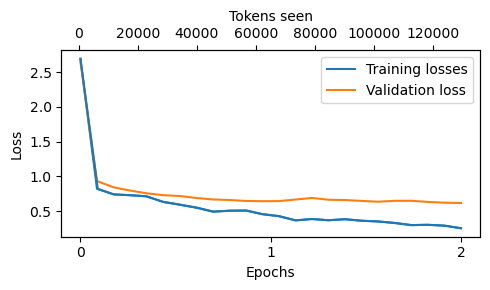

In [44]:
plot_losses(epochs_tensor, tokens_seen, train_losses, val_losses)

In [45]:
for entry in test_data[:3]:
    input_text = format_input(entry)
    token_ids = generate(
        model=model,
        idx=text_to_token_ids(input_text, tokenizer),
        max_new_tokens=256,
        context_size=BASE_CONFIG['context_length'],
        eos_id=50256
    )
    generated_text = token_ids_to_text(token_ids, tokenizer)
    print(f"\n Raw generated text is: \n>> {generated_text}")
    response = generated_text[len(input_text):].replace("### Response:", "").strip()

    print(f"\n Input text is: \n>> {input_text}")
    print(f"\nCorrect response: \n>> {entry['output']}")
    print(f"\nModel Response: \n>> {response}")
    print(100*'-')


 Raw generated text is: 
>> Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
Rewrite the sentence using a simile.

### Input:
The car is very fast.

### Response:
The car is as fast as a bullet.

 Input text is: 
>> Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
Rewrite the sentence using a simile.

### Input:
The car is very fast.

Correct response: 
>> The car is as fast as lightning.

Model Response: 
>> The car is as fast as a bullet.
----------------------------------------------------------------------------------------------------

 Raw generated text is: 
>> Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
What type of cloud is typically associated with thunderstorms?

### Response:
A thunderstorm is typically associated with a type of cloud called a cir

In [46]:
from tqdm import tqdm

for i, entry in tqdm(enumerate(test_data), total=len(test_data)):
    input_text = format_input(entry)
    token_ids = generate(
        model=model,
        idx=text_to_token_ids(input_text, tokenizer),
        max_new_tokens=256,
        context_size=BASE_CONFIG['context_length'],
        eos_id=50256
    )
    generated_text = token_ids_to_text(token_ids, tokenizer)
    # print(generated_text)
    response = generated_text[len(input_text):].replace("### Response:", "").strip()

    test_data[i]['model_response'] = response

with open('instruction-test-data-with-response.json', 'w') as f:
    json.dump(test_data, f, indent=4)

100%|██████████| 110/110 [10:46<00:00,  5.87s/it]


In [47]:
# save the model
file_path = 'gpt2-medium-sft.pth'
torch.save(model.state_dict(), file_path)

In [48]:
import psutil

def check_if_running(process_name):
    running = False
    for proc in psutil.process_iter(["name"]):
        if process_name in proc.info['name']:
            running = True
            break
    
    return running

In [50]:
ollama_running = check_if_running('ollama')
ollama_running

True

In [54]:
import urllib.request
import json

def query_model(prompt, model="llama3", url="http://localhost:11434/api/chat"):
    data = {
        "model": model,
        "messages": [
            {
                "role": "user",
                "content": prompt
            }
        ],
        "options": {
            "seed": 123,
            "temperature": 0,
        }
    }
    payload = json.dumps(data).encode("utf-8")
    request = urllib.request.Request(url, data=payload, method='POST')
    request.add_header("Content-Type", "application/json")

    response_data = ""
    with urllib.request.urlopen(request) as response:
        while True:
            line = response.readline().decode('utf-8')
            if not line:
                break
            response_json = json.loads(line)
            response_data += response_json['message']['content']
    
    return response_data

In [55]:
res = query_model('What do Llamas eat?')
print(res)

Llamas are herbivores, which means they primarily feed on plant-based foods. Their diet typically consists of:

1. Grasses: Llamas love to graze on various types of grasses, including tall grasses, short grasses, and even weeds.
2. Hay: High-quality hay, such as alfalfa or timothy hay, is a staple in a llama's diet. They enjoy the sweet taste and texture of fresh hay.
3. Grains: Llamas may receive grains like oats, barley, or corn as part of their daily ration. However, it's essential to provide these grains in moderation, as they can be high in calories.
4. Fruits and vegetables: Llamas enjoy a variety of fruits and veggies, such as apples, carrots, sweet potatoes, and leafy greens like kale or spinach.
5. Minerals: Llamas require access to mineral supplements, which help maintain their overall health and well-being.

In the wild, llamas might also eat:

1. Leaves: They'll munch on leaves from trees and shrubs, including plants like willow, alder, and birch.
2. Bark: In some cases, ll

In [57]:
file_path = "instruction-test-data-with-response.json"

with open(file_path, "r") as file:
    test_data = json.load(file)

In [62]:
test_data[0]['model_response'].replace("### Response:", "").strip()

'The car is as fast as a bullet.'

In [64]:
print(format_input(test_data[0]))

Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
Rewrite the sentence using a simile.

### Input:
The car is very fast.


In [77]:
for entry in test_data[:5]:
    model_response = entry['model_response'].replace("### Response:", "").strip()
    prompt = (
        f"Given the input `{format_input(entry)}` "
        f"and correct output `{entry['output']}`, "
        f"score the model response `{model_response}`"
        f" on a scale from 0 to 100, where 100 is the best score. "
        f"Respond with the integer number only"
    )
    print(query_model(prompt))
    

95
20
98
60
20


In [92]:
def generate_model_scores(json_data, json_key, model='llama3'):
    scores = []
    for entry in tqdm(json_data, desc="Scoring entities"):
        model_response = entry['model_response'].replace("### Response:", "").strip()
        prompt = (
            f"Given the input `{format_input(entry)}` "
            f"and correct output `{entry['output']}`, "
            f"score the model response `{model_response}`"
            f" on a scale from 0 to 100, where 100 is the best score. "
            f"Respond with the integer number only"
        )
        score = query_model(prompt, model)
        try:
            scores.append(int(score))
        except ValueError as e:
            print(f"Could not convert score to integer: {score}, {e}")
            continue
    
    return scores

In [93]:
scores = generate_model_scores(test_data, 'model_response', model='llama3.1')

Scoring entities:   5%|▌         | 6/110 [00:06<01:55,  1.11s/it]

Could not convert score to integer: 50

Explanation: The model response is not entirely accurate because it simply repeats the input sentence instead of rewriting it as instructed. A better response would be "The lecture was delivered clearly." which is the correct output provided in the example., invalid literal for int() with base 10: '50\n\nExplanation: The model response is not entirely accurate because it simply repeats the input sentence instead of rewriting it as instructed. A better response would be "The lecture was delivere


Scoring entities:  31%|███       | 34/110 [00:24<01:27,  1.15s/it]

Could not convert score to integer: 20

The model response "7 kilometers is 7 meters." is incorrect because it does not take into account that 1 kilometer is equal to 1000 meters. Therefore, 7 kilometers would be 7000 meters, not 7 meters., invalid literal for int() with base 10: '20\n\nThe model response "7 kilometers is 7 meters." is incorrect because it does not take into account that 1 kilometer is equal to 1000 meters. Therefore, 7 kilometers would be 7000 meters, not 7 m


Scoring entities:  57%|█████▋    | 63/110 [00:38<00:38,  1.24it/s]

Could not convert score to integer: 20
The model response is incorrect because it states that the boiling point of sulfur is 78.5 degrees Celsius, whereas the correct answer is 444.6 degrees Celsius., invalid literal for int() with base 10: '20\nThe model response is incorrect because it states that the boiling point of sulfur is 78.5 degrees Celsius, whereas the correct answer is 444.6 degrees Celsius.'


Scoring entities: 100%|██████████| 110/110 [01:06<00:00,  1.66it/s]


In [94]:
len(scores)

107

In [95]:
sum(scores)

5614

In [96]:
scores

[95,
 13,
 95,
 20,
 50,
 20,
 95,
 95,
 50,
 95,
 100,
 50,
 20,
 13,
 50,
 95,
 95,
 20,
 95,
 22,
 60,
 20,
 95,
 20,
 60,
 20,
 8,
 100,
 20,
 20,
 80,
 4,
 100,
 20,
 100,
 100,
 20,
 10,
 80,
 100,
 24,
 20,
 20,
 80,
 6,
 100,
 100,
 100,
 50,
 100,
 55,
 20,
 5,
 60,
 95,
 20,
 95,
 95,
 95,
 50,
 5,
 95,
 20,
 20,
 100,
 95,
 75,
 50,
 60,
 60,
 95,
 0,
 50,
 95,
 1,
 20,
 95,
 95,
 100,
 5,
 50,
 20,
 20,
 95,
 6,
 5,
 20,
 50,
 50,
 95,
 20,
 10,
 50,
 20,
 95,
 20,
 80,
 95,
 20,
 20,
 5,
 4,
 95,
 20,
 24,
 50,
 24]

In [97]:
sum(scores) / len(scores)

52.467289719626166